In [1]:
import numpy as np
from onset_detection import detected_samples
import matplotlib.pyplot as plt
import helper
import scipy.io.wavfile as wav
from datetime import datetime
import least_squares
import sys
sys.path.append('/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi')
from midi import process_midi_to_note_info, notes_to_chords, dict_to_frequency_list, plot_piece



/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/GP_models/least_squares.py:17: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wav.read(wav_file)


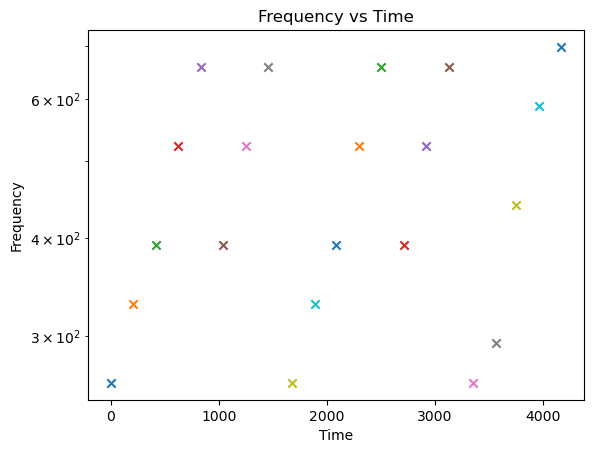

[[261.6255653005986], [329.6275569128699], [391.99543598174927], [523.2511306011972], [659.2551138257398], [391.99543598174927], [523.2511306011972], [659.2551138257398], [261.6255653005986], [329.6275569128699], [391.99543598174927], [523.2511306011972], [659.2551138257398], [391.99543598174927], [523.2511306011972], [659.2551138257398], [261.6255653005986], [293.6647679174076], [440.0], [587.3295358348151], [698.4564628660078], [440.0], [587.3295358348151], [698.4564628660078], [261.6255653005986], [293.6647679174076], [440.0], [587.3295358348151], [698.4564628660078], [440.0], [587.3295358348151], [698.4564628660078], [246.94165062806206], [293.6647679174076], [391.99543598174927], [587.3295358348151], [698.4564628660078], [391.99543598174927], [587.3295358348151], [698.4564628660078], [246.94165062806206], [293.6647679174076], [391.99543598174927], [587.3295358348151], [698.4564628660078], [391.99543598174927], [587.3295358348151], [698.4564628660078], [261.6255653005986], [329.627

In [16]:
notes = process_midi_to_note_info(
    '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/midi_files/Prelude1.midi')
chords = notes_to_chords(notes, False)

plot_piece(chords, 20)
plt.show()
score = dict_to_frequency_list(chords)
print(score)

In [53]:
hop = 15000
sample_len = 1000

/var/folders/n4/k97yk30s1wn32d7y6729kph80000gn/T/ipykernel_17648/3161505163.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wav.read(path)


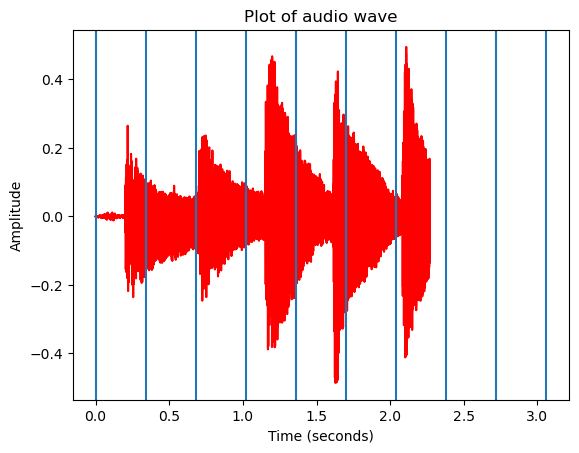

In [57]:
path =     '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/bach_3.wav'
sample_rate, data = wav.read(path)

audio_duration = len(data)/sample_rate


time_samples = np.linspace(0, audio_duration, len(data))
sample_indices = np.arange(0, len(data), hop)
sample_data = [data[index:index+sample_len] for index in sample_indices]
helper.plot_audio(time_samples[:100000], data[:100000])
for i in sample_indices[:10]:
    plt.axvline(i/sample_rate)

In [7]:
time_samples = np.linspace(0, 1000/sample_rate, len(sample_data[0]))
for i in sample_data[:30]:
    print(np.sum(abs(i)))
print(np.exp(-helper.relative_nlml(time_samples, sample_data[1],M=9, T=0.465, v=2.37, f=[392])))

0it [00:00, ?it/s]

1it [00:00, 12.66it/s]

4.193002943498868
50.96856072831724
56.91980480052007
128.49073555268114
66.65595253691572
51.991810732128215
132.55650974776654
79.87660051709099
48.81489008839708
33.14248727672748
40.68125327496
41.23942471900955
67.48991325228417
66.93710647161788
44.42800660927605
106.85705214439076
80.84305691160262
60.324955557473004
157.29427003889577
47.53046760441066
56.95898939545441
69.88733050266092
66.4848558328813
42.65047089170548
47.56926074805597
50.1898535351429
47.04639999630308
59.51227314503558
53.026406756514916
72.52749823800696
0.0017070086698337146


In [58]:
def oltw(sample_data: list, score: list, time_samples: np.ndarray, n: int, pedal: bool = False):
    note_num, audio_num = 0, 0
    path = []
    for sample in sample_data[:-n]:
        if np.sum(abs(sample))<10:
            print("here")
        else:
            probabilities = []
            num_lookahead = min(len(score) - note_num + 1, n)
            for i in range(num_lookahead):
                probabilities.append(helper.stable_nlml(time_samples=time_samples, Y=sample, T=0.465, v=2.37, M=13,sigma_f=5, normalised=False,f=score[note_num+i]))
            
            # priors = 1/np.arange(1, num_lookahead+1)
            priors = np.ones(num_lookahead)
            probabilities = np.array(probabilities)
            probabilities = probabilities * priors

            index = np.argmin(probabilities)

            note_num += index
        audio_num += 1
        path.append((note_num, audio_num))
    return path


In [59]:
sample_time_samples = np.linspace(0, sample_len/sample_rate, len(sample_data[0]))

path = oltw(sample_data[:30], score, sample_time_samples, 3)

1it [00:00,  9.06it/s]
0it [00:00, ?it/s]

here


1it [00:00,  9.20it/s]
1it [00:00,  8.75it/s]
1it [00:00, 11.10it/s]
1it [00:00, 12.22it/s]
1it [00:00, 10.38it/s]
1it [00:00, 11.73it/s]
1it [00:00, 13.16it/s]
1it [00:00, 12.23it/s]
1it [00:00, 12.85it/s]
1it [00:00, 12.19it/s]
1it [00:00, 13.35it/s]
1it [00:00, 12.30it/s]
1it [00:00, 12.77it/s]
1it [00:00, 13.26it/s]
1it [00:00, 12.87it/s]
1it [00:00, 13.04it/s]
1it [00:00, 12.69it/s]
1it [00:00, 13.53it/s]
1it [00:00, 13.50it/s]
1it [00:00, 12.74it/s]
1it [00:00, 12.50it/s]
1it [00:00, 12.72it/s]
1it [00:00, 13.14it/s]
1it [00:00, 12.87it/s]
1it [00:00, 12.98it/s]
1it [00:00, 13.72it/s]
1it [00:00, 12.77it/s]
1it [00:00, 12.57it/s]
1it [00:00, 12.04it/s]
1it [00:00, 12.94it/s]
1it [00:00, 13.46it/s]
1it [00:00, 14.96it/s]
1it [00:00, 11.69it/s]
1it [00:00, 11.94it/s]
1it [00:00, 14.32it/s]
1it [00:00, 14.86it/s]
1it [00:00, 14.10it/s]
1it [00:00, 10.84it/s]
1it [00:00,  8.11it/s]
1it [00:00,  7.81it/s]
1it [00:00, 14.31it/s]
1it [00:00, 14.48it/s]
1it [00:00, 14.58it/s]
1it [00:00,

In [60]:
print(path)

[(0, 1), (0, 2), (0, 3), (1, 4), (2, 5), (3, 6), (3, 7), (4, 8), (5, 9), (6, 10), (8, 11), (9, 12), (9, 13), (9, 14), (9, 15), (10, 16), (11, 17), (11, 18), (12, 19), (13, 20), (14, 21), (16, 22), (17, 23), (17, 24), (17, 25), (18, 26), (18, 27)]


/var/folders/n4/k97yk30s1wn32d7y6729kph80000gn/T/ipykernel_17648/3699686536.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wav.read(link)


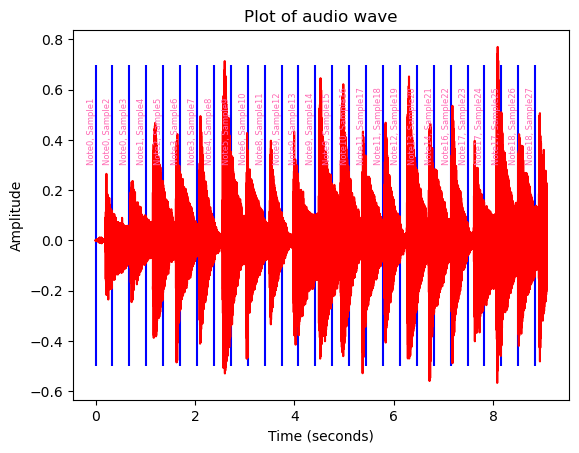

In [63]:
link =     '/Users/josephine/Documents/Engineering /Part IIB/Score alignment project/Score-follower/wav_files/bach_3.wav'
sample_rate, data = wav.read(link)
data=data[:400000]
audio_duration = len(data)/sample_rate
time_samples = np.linspace(0, audio_duration, len(data))
helper.plot_audio(time_samples, data)

for i in range(len(sample_indices[:27])):
    plt.vlines(sample_indices[i]/sample_rate, ymin=-
                       0.5, ymax=0.7, colors='blue', zorder=2)
    note = path[i][0]
    sample = path[i][1]
    plt.text(sample_indices[i]/sample_rate, 0.3, f'Note{note}, Sample{sample}', color='#FF69B4', ha='right', va='bottom', rotation=90, fontsize=6)
    

In [ ]:
helper.

15.286218989498593


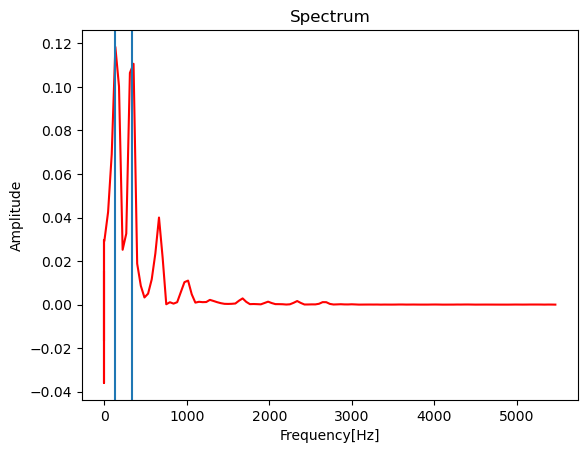

In [100]:
helper.plot_audio(sample_time_samples, sample_data[2])
helper.plot_fft(sample_data[2])
plt.axvline(261/2)
plt.axvline(330)
print(np.sum(abs(sample_data[3])))

In [91]:
print((-helper.relative_nlml(sample_time_samples, sample_data[2],M=15,sigma_f=5,  f=[261], T=0.465, v=2.37 )))
print((-helper.relative_nlml(sample_time_samples, sample_data[2],M=15, sigma_f=5, f=[330], T=0.465, v=2.37 )))

1it [00:00,  7.12it/s]
1it [00:00,  9.50it/s]

-3.658139087882506
-2.4897286877838316
